# Projet 5: Analyse exploratoire

Objectif : effectuer une analyse des données fournis par Olist, repérer les plus pertinentes et voir les features à créer dans l'objectif de pouvoir effectuer une clusterisation des clients selon leur profil d'acheteur.

Résultat : un fichier d'une ligne par client contenant les variables RFM, ainsi que le délai de livraison et la note moyenne que le client à donné aux différentes commandes.

## Import des bibliotheques et des données

Objectif: Importer les bibliothèques nécessaires au fonctionnement du code et créer une fonction d'analyse de dataframe.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score, homogeneity_score
from math import pi
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import datetime
import os

# Définir la taille de police par défaut
plt.rcParams.update({"font.size": 14})


def data_description(datafrr):
    """
    Affiche les informations de base et les statistiques descriptives d'un DataFrame.

    Parameters:
    datafrr (pd.DataFrame): Le DataFrame à décrire

    """
    datafrr.info()

    dimension_dataframe = datafrr.shape
    print(f"Nombre de lignes pour {datafrr.name}: ", dimension_dataframe[0])
    print(f"Nombre de colonnes pour {datafrr.name}: ", dimension_dataframe[1])

    types_dataframe = datafrr.dtypes
    print(types_dataframe)

    pourcentage_donnees_vides = (datafrr.isnull().sum() / len(datafrr)) * 100
    print("\nPourcentage de données vides par colonne :")
    print(pourcentage_donnees_vides)

    pourcentage_total_donnees_vides = (
        datafrr.isnull().sum().sum() / (datafrr.shape[0] * datafrr.shape[1])
    ) * 100
    print(
        f"\nPourcentage total de données vides dans le DataFrame : "
        f"{pourcentage_total_donnees_vides:.2f}%"
    )

    plt.figure(figsize=(10, 6))
    plt.imshow(
        pourcentage_donnees_vides.values.reshape(1, -1),
        cmap="viridis",
        aspect="auto",
        interpolation="none",
    )
    plt.title(f"Pourcentage de données manquantes par colonne - {datafrr.name}")
    plt.xlabel("Colonnes")
    plt.ylabel("Pourcentage")
    plt.colorbar()
    plt.show()

    dataframe_data_desc = datafrr.describe()
    print(dataframe_data_desc)


Objectif: Importer les différentes tables préalablement converti en csv avec DBreaver.

In [20]:
#Chemin vers le dossier
base_path = "D:/OpenClassroom/Projet_5/"

#Création des dataframes

customers_table = pd.read_csv(os.path.join(base_path, "customers.csv"))
geolocs_table = pd.read_csv(os.path.join(base_path, "geoloc.csv"))
orders_items_table = pd.read_csv(os.path.join(base_path, "order_items.csv"))
orders_pymts_table = pd.read_csv(os.path.join(base_path, "order_pymts.csv"))
order_review_table = pd.read_csv(os.path.join(base_path, "order_reviews.csv"))
orders_table = pd.read_csv(os.path.join(base_path, "orders.csv"))
products_table = pd.read_csv(os.path.join(base_path, "products.csv"))
sellers_table = pd.read_csv(os.path.join(base_path, "sellers.csv"))

## Analyses clients et vendeurs

### Localisation vendeurs

Objectif: Obtenir des indications visuelles quant à la répartition des différents vendeurs selon les états.

Text(0, 0.5, 'Nombre de vendeurs')

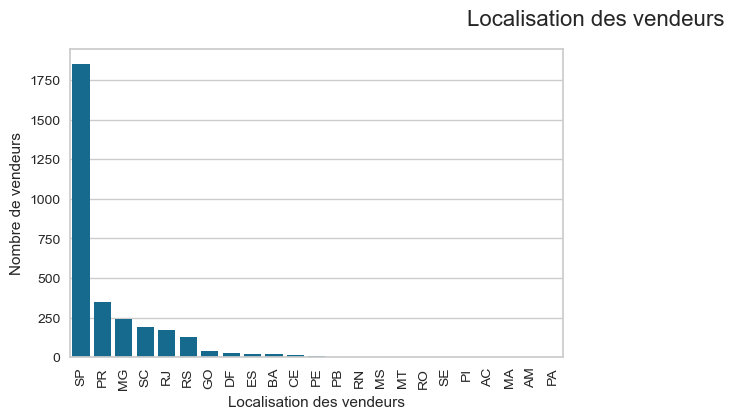

In [21]:
# Répartition localisation vendeurs
fig = plt.figure(1, figsize=(14, 4))
fig.suptitle("Localisation des vendeurs", fontsize=16)

plt.subplot(121)
sns.barplot(
    y=sellers_table["seller_state"].value_counts(),
    x=sellers_table["seller_state"].value_counts().index,
)
plt.xticks(rotation=90)
plt.xlabel("Localisation des vendeurs")
plt.ylabel("Nombre de vendeurs")

## Localisation clients

Objectif: Obtenir des indications visuelles quant à la répartition des clients selon les états.

Text(0, 0.5, 'Nombres de clients')

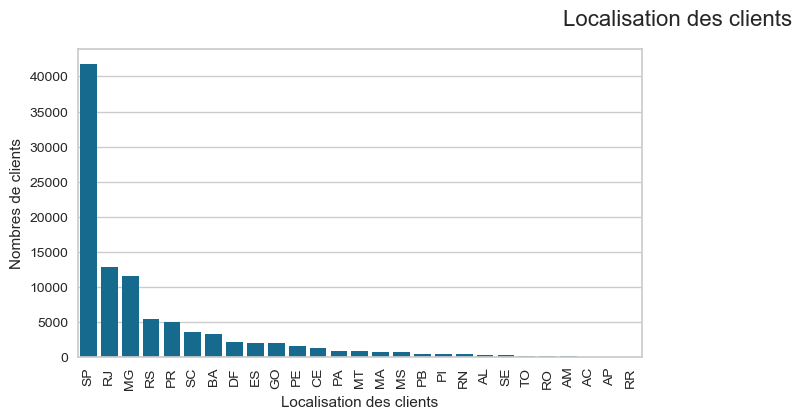

In [22]:
# Répartition de la localisation des clients
fig = plt.figure(1, figsize=(16, 4))
fig.suptitle("Localisation des clients", fontsize=16)

plt.subplot(121)
sns.barplot(
    y=customers_table["customer_state"].value_counts(),
    x=customers_table["customer_state"].value_counts().index,
)
plt.xticks(rotation=90)
plt.xlabel("Localisation des clients")
plt.ylabel("Nombres de clients")

## Analyses des commandes

### Article par commande

Objectif : Objectif: Obtenir des indications visuelles quant aux nombres de produit contenu dans chaque commande.

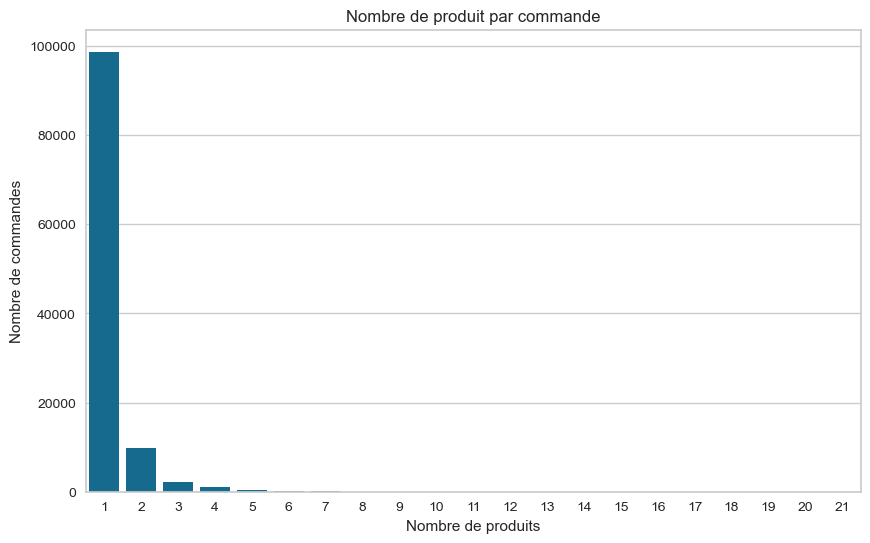

In [23]:
# Compter les occurrences de chaque ID d'article de commande
item_counts = orders_items_table["order_item_id"].value_counts()

# Créer un DataFrame à partir des comptes
count_order_product = pd.DataFrame(
    {"Number of products": item_counts.index, "Number of orders": item_counts.values}
)

# Tracer en utilisant seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Number of products", y="Number of orders", data=count_order_product)
plt.title("Nombre de produit par commande")
plt.xlabel("Nombre de produits")
plt.ylabel("Nombre de commandes")
plt.show()

### Weight value et prix

Objectif: vérifier s'il existe un rapport entre le poids des produits et leur prix

(0.0, 2000.0)

<Figure size 800x800 with 0 Axes>

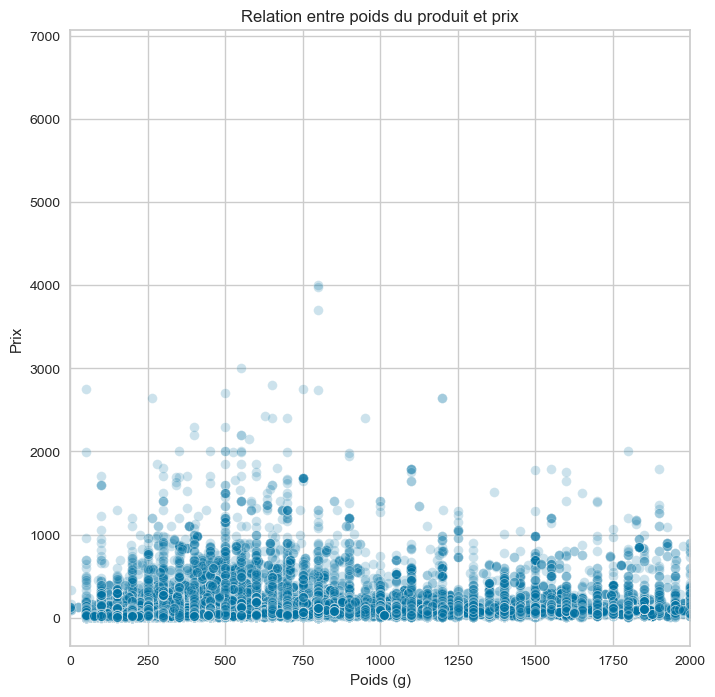

In [24]:
fig = plt.figure(1, figsize=(8, 8))
order_weight_price = pd.merge(
    products_table, orders_items_table, how="left", on=["product_id", "product_id"]
)

# Histogramme weight value et prix
plt.figure(figsize=(8, 8))
sns.scatterplot(x="product_weight_g", y="price", data=order_weight_price, alpha=0.2)
plt.title("Relation entre poids du produit et prix")
plt.xlabel("Poids (g)")
plt.ylabel("Prix")
plt.xlim([0, 2000])

## Analyses des paiements

### Paiement

Objectif: Vérifier la répartition des valeurs de paiement.

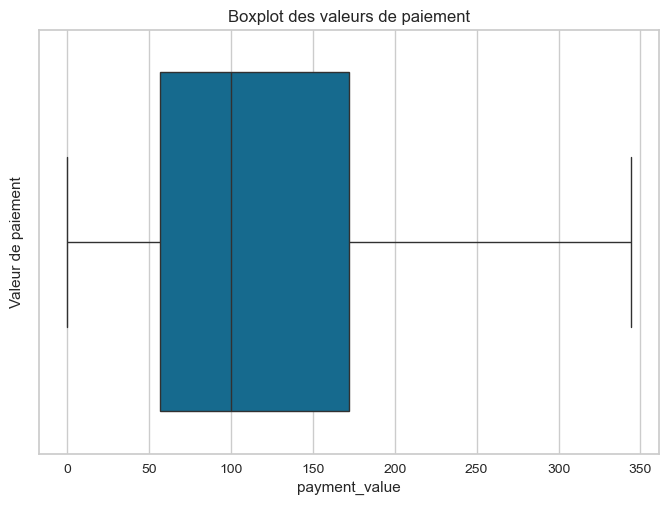

In [25]:
# Boxplot pour "payment_value"
sns.boxplot(x=orders_pymts_table["payment_value"], showfliers=False)
plt.ylabel("Valeur de paiement")
plt.title("Boxplot des valeurs de paiement")
plt.show()

### Moyen de paiement

Objectif: Vérifier les différents moyens de paiement utilisé par les clients ainsi que leur répartition.

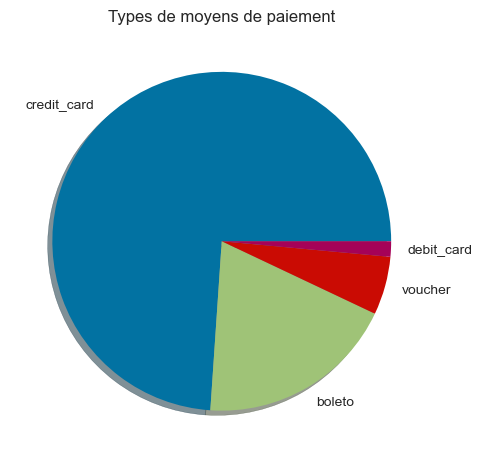

In [26]:
# Valeurs uniques par type de paiements
orders_pymts_table["payment_type"].value_counts()

# Suppression des paiements de type "not_defined"
payment_type = ["credit_card", "boleto", "voucher", "debit_card"]
payments = orders_pymts_table[orders_pymts_table["payment_type"].isin(payment_type)]

# Pieplot des différents moyens de paiements
plt.title("Types de moyens de paiement")
fig = plt.figure(1, figsize=(8, 8))
plt.pie(
    payments["payment_type"].value_counts(),
    labels=payments["payment_type"].unique(),
    shadow=True,
)
plt.show()

### Montant selon moyen de paiement

Objectif: Vérifier la répartition des valeurs de paiement selon les différents moyens de paiement.

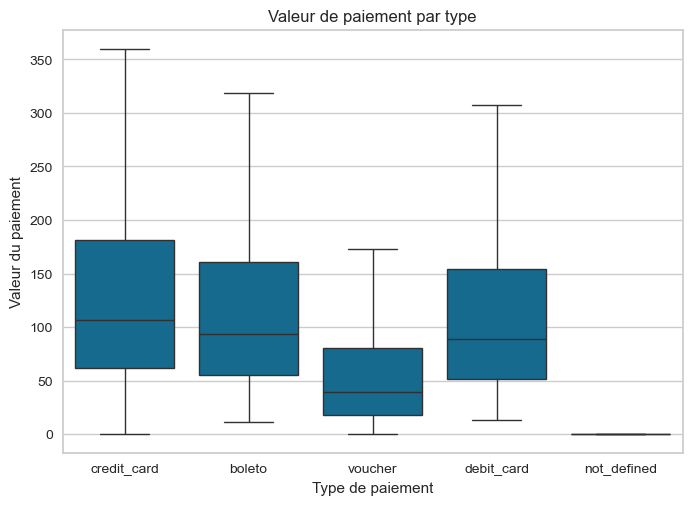

In [27]:
# Boxplot pour chaque type de paiement
plt.title("Valeur de paiement par type")
sns.boxplot(
    data=orders_pymts_table, y="payment_value", x="payment_type", showfliers=False
)
plt.ylabel("Valeur du paiement")
plt.xlabel("Type de paiement")
plt.show()

Objectif: supprimer les lignes de paiement not_defined qui semble être une erreur

In [28]:
# Suppression des lignes où payment_type est 'not_defined'
orders_pymts_table = orders_pymts_table[
    orders_pymts_table["payment_type"] != "not_defined"
]

## Analyses de l'expérience client

### Delai de livraison

Objectif: Créer une variable représentant le nombre de jours de délai des livraisons.

In [29]:
# Conversion des colonnes en datetime
orders_table["order_estimated_delivery_date"] = pd.to_datetime(
    orders_table["order_estimated_delivery_date"]
)
orders_table["order_delivered_customer_date"] = pd.to_datetime(
    orders_table["order_delivered_customer_date"]
)

# Calcul de la différence entre la date de livraison estimée et la date de livraison réelle
orders_table["diff_days"] = (
    orders_table["order_delivered_customer_date"]
    - orders_table["order_estimated_delivery_date"]
).dt.days

### graphique

Objectif : Créer une représentation graphique de la répartition des jours de délai.

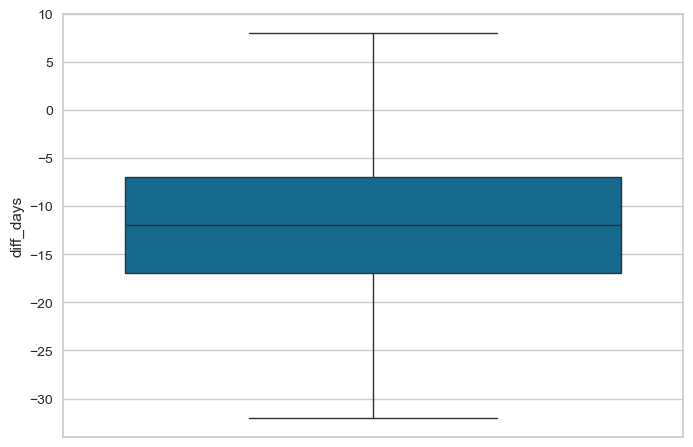

In [30]:
# Boxplot pour "diff_days"
sns.boxplot(orders_table["diff_days"], showfliers=False)
plt.show()

### Review score

Objectif : Obtenir une visualisation de la distribution des reviews scores.

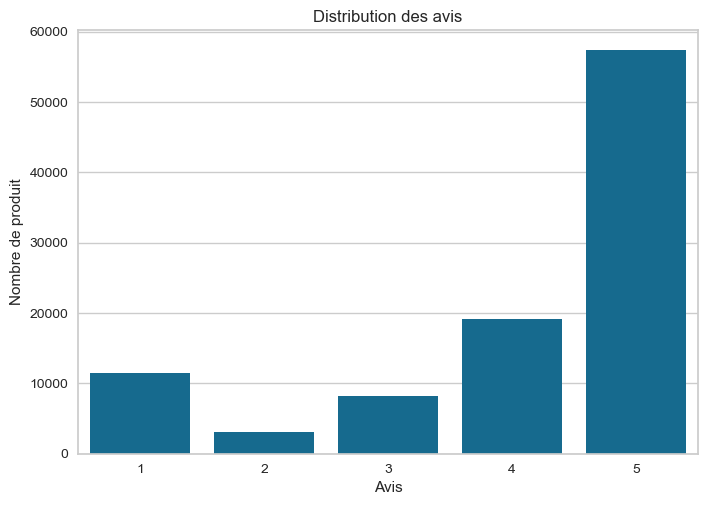

In [31]:
review_score = order_review_table["review_score"].value_counts()

# Création d'un df pour le plot
review_score_df = review_score.reset_index()
review_score_df.columns = ["Review Score", "Number of Reviews"]

# Barplot
sns.barplot(x="Review Score", y="Number of Reviews", data=review_score_df)
plt.ylabel("Nombre de produit")
plt.xlabel("Avis")
plt.title("Distribution des avis")
plt.show()

### Panier moyen par mois

Objectif : Obtenir des détails par mois sur le panier moyen ainsi que sur le nombre de commande.

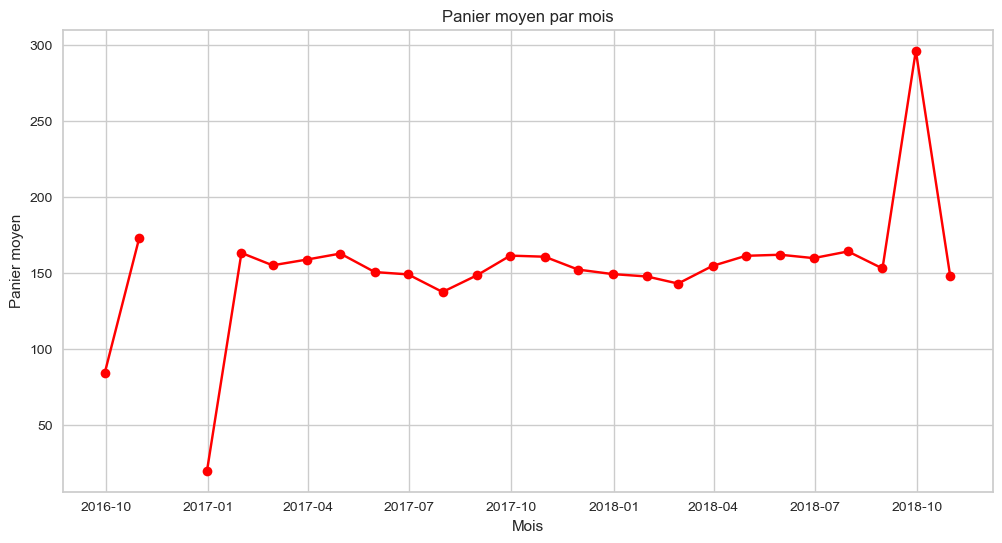

In [32]:
order_payment = pd.merge(
    orders_table, orders_pymts_table, how="left", on=["order_id", "order_id"]
)

# Conversion de la colonne de date en datetime
order_payment["order_purchase_timestamp"] = pd.to_datetime(
    order_payment["order_purchase_timestamp"]
)

# Calcul du panier moyen
order_payment.set_index("order_purchase_timestamp", inplace=True)
monthly_average = order_payment["payment_value"].resample("M").mean()

# Visualisation de la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(monthly_average.index, monthly_average, marker="o", linestyle="-", color="red")
plt.title("Panier moyen par mois")
plt.xlabel("Mois")
plt.ylabel("Panier moyen")
plt.grid(True)
plt.show()

### Commande par mois

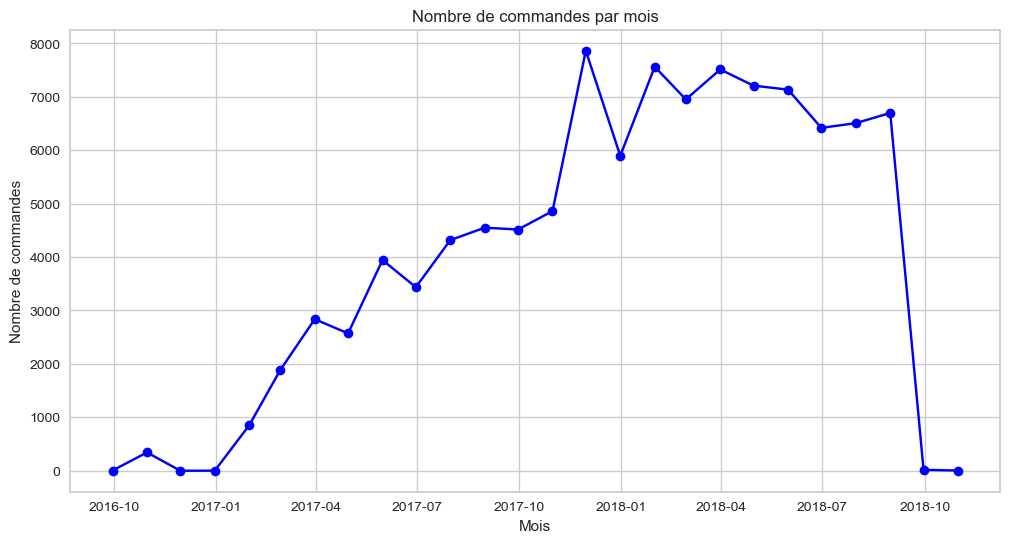

In [33]:
# Calcul du nombre de commandes par mois
monthly_orders = order_payment.resample("M").size()

# Visualisation de la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders.index, monthly_orders, marker="o", linestyle="-", color="blue")
plt.title("Nombre de commandes par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de commandes")
plt.grid(True)
plt.show()

### Note moyenne selon le nombre de produits achetés

Objectif : Vérifier l'existence d'un rapport entre la note et le nombre d'articles dans une commande.

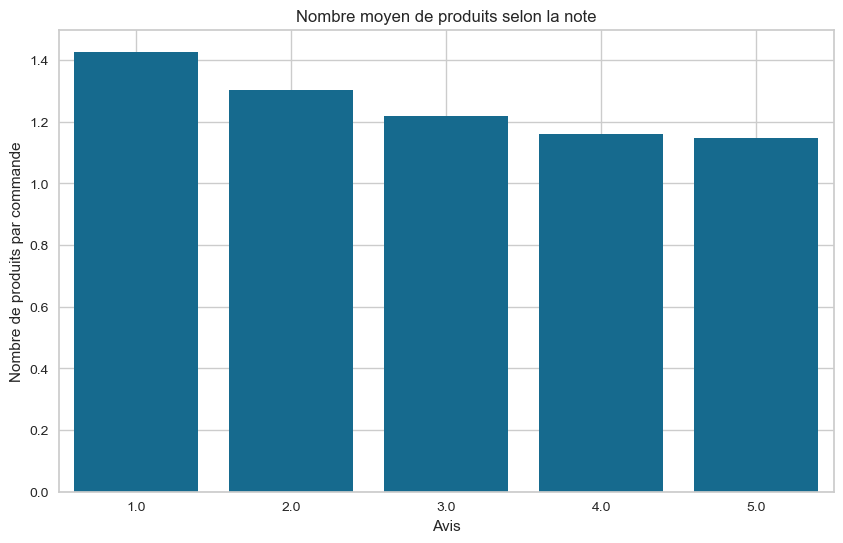

In [34]:
# Jonction des DataFrames
review_score_order_item = pd.merge(
    orders_items_table, order_review_table, how="left", on="order_id"
)

# Calcul du nombre moyen de produits selon la note
average_product_per_order_review = (
    review_score_order_item.groupby("review_score")["order_item_id"]
    .mean()
    .reset_index()
)

# Création du graphique
plt.figure(figsize=(10, 6))
sns.barplot(x="review_score", y="order_item_id", data=average_product_per_order_review)
plt.title("Nombre moyen de produits selon la note")
plt.xlabel("Avis")
plt.ylabel("Nombre de produits par commande")
plt.grid(True)
plt.show()

### Panier moyen selon reviews

Objectif : Vérifier l'existence d'un rapport entre la note et le panier moyen d'une commande.

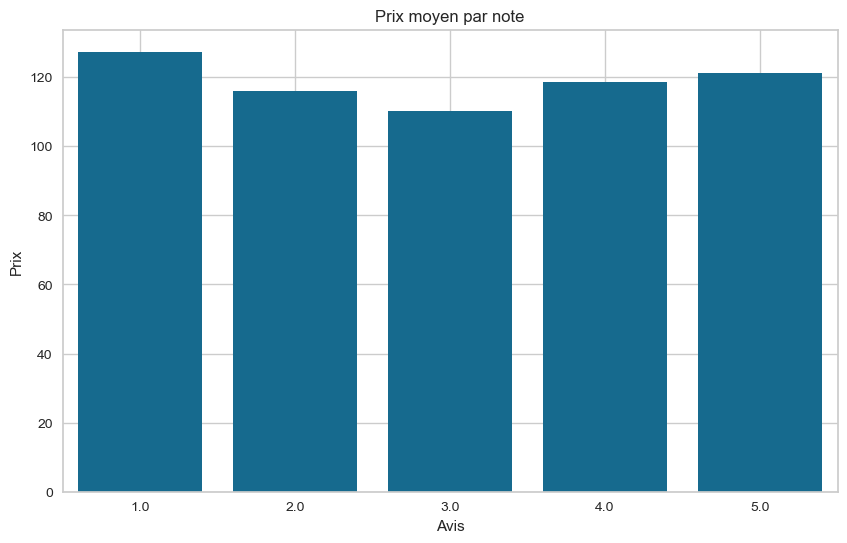

In [35]:
# Calcul du prix moyen selon la note
average_product_per_order_review = (
    review_score_order_item.groupby("review_score")["price"].mean().reset_index()
)

# Création du graphique
plt.figure(figsize=(10, 6))
sns.barplot(x="review_score", y="price", data=average_product_per_order_review)
plt.title("Prix moyen par note")
plt.xlabel("Avis")
plt.ylabel("Prix")
plt.grid(True)
plt.show()

### Evolution avis moyen selon le temps de livraison

Objectif : Vérifier l'existence d'un rapport entre la note et le délai de livraison d'une commande.

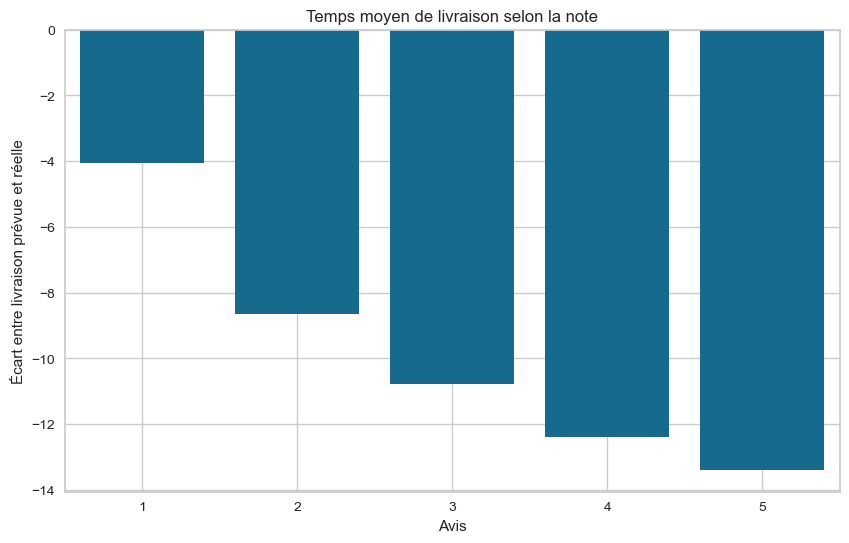

In [36]:
# Jonction des DataFrames
review_score_per_delay = pd.merge(
    orders_table[["order_id", "diff_days"]],
    order_review_table[["order_id", "review_score"]],
    on="order_id",
    how="inner",
)

# Calcul du délai moyen de livraison selon la note
average_delivery_time_by_score = (
    review_score_per_delay.groupby("review_score")["diff_days"].mean().reset_index()
)

# Création du graphique
plt.figure(figsize=(10, 6))
sns.barplot(x="review_score", y="diff_days", data=average_delivery_time_by_score)
plt.title("Temps moyen de livraison selon la note")
plt.xlabel("Avis")
plt.ylabel("Écart entre livraison prévue et réelle")
plt.grid(True)
plt.show()

msno.matrix(base_data)

## Création fichier rfm

Objectif : Créer un nouveau dataframe contenant les données [RFM](https://www.e-marketing.fr/Definitions-Glossaire/-recence-frequence-valeur-238820.htm#:~:text=Le%20scoring%20RFM%20est%20un,la%20p%C3%A9riodicit%C3%A9%20de%20ses%20activit%C3%A9s.), ainsi que des informations sur les notes moyennes des commandes clients et le délai moyen de livraison pour l'ensemble de leurs commandes.

In [37]:
# Conversion des dates en datetime
orders_table["order_purchase_timestamp"] = pd.to_datetime(
    orders_table["order_purchase_timestamp"]
)
orders_table["order_estimated_delivery_date"] = pd.to_datetime(
    orders_table["order_estimated_delivery_date"]
)
orders_table["order_delivered_customer_date"] = pd.to_datetime(
    orders_table["order_delivered_customer_date"]
)

# Calcul de la date maximale de commande
max_date = orders_table["order_purchase_timestamp"].max()

# Filtre sur les années supérieures à 2016
date_reference = pd.Timestamp("2016-12-31")
recent_orders = orders_table[orders_table["order_purchase_timestamp"] > date_reference]

# Fusion des DataFrames avec des suffixes pour éviter les colonnes en double
merged_df = customers_table.merge(
    recent_orders, on="customer_id", suffixes=("", "_recent")
)
merged_df = merged_df.merge(orders_items_table, on="order_id", suffixes=("", "_item"))
merged_df = merged_df.merge(
    order_review_table, on="order_id", how="left", suffixes=("", "_review")
)

# Calcul de la récence (la date la plus récente d'achat)
recency = (
    merged_df.groupby(["customer_id", "customer_city", "customer_state"])[
        "order_purchase_timestamp"
    ]
    .max()
    .reset_index()
)
recency["recency"] = (max_date - recency["order_purchase_timestamp"]).dt.days
recency.rename(columns={"order_purchase_timestamp": "date"}, inplace=True)

# Calcul du montant total dépensé par client
monetary = (
    merged_df.groupby(["customer_id", "customer_city", "customer_state"])["price"]
    .sum()
    .reset_index()
)
monetary.rename(columns={"price": "monetary"}, inplace=True)

# Calcul de la fréquence d'achats par client
frequency = (
    merged_df.groupby(["customer_id", "customer_city", "customer_state"])["order_id"]
    .count()
    .reset_index()
)
frequency.rename(columns={"order_id": "frequency"}, inplace=True)

# Calcul du retard ou de l'avance de livraison
merged_df["delay"] = (
    merged_df["order_estimated_delivery_date"]
    - merged_df["order_delivered_customer_date"]
).dt.days
delay = (
    merged_df.groupby(["customer_id", "customer_city", "customer_state"])["delay"]
    .mean()
    .reset_index()
)
delay["delay"] = delay["delay"].round()

# Calcul de la note moyenne des avis
average_review_score = (
    merged_df.groupby(["customer_id", "customer_city", "customer_state"])[
        "review_score"
    ]
    .mean()
    .reset_index()
)
average_review_score.rename(
    columns={"review_score": "average_review_score"}, inplace=True
)

# Fusion de l'ensemble des agrégations
rfm_df = recency.merge(monetary, on=["customer_id", "customer_city", "customer_state"])
rfm_df = rfm_df.merge(frequency, on=["customer_id", "customer_city", "customer_state"])
rfm_df = rfm_df.merge(delay, on=["customer_id", "customer_city", "customer_state"])
rfm_df = rfm_df.merge(
    average_review_score, on=["customer_id", "customer_city", "customer_state"]
)

Objectif: obtenir des informations basiques sur le nouveau dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98351 entries, 0 to 98350
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           98351 non-null  object        
 1   customer_city         98351 non-null  object        
 2   customer_state        98351 non-null  object        
 3   date                  98351 non-null  datetime64[ns]
 4   recency               98351 non-null  int64         
 5   monetary              98351 non-null  float64       
 6   frequency             98351 non-null  int64         
 7   delay                 96203 non-null  float64       
 8   average_review_score  97607 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 6.8+ MB
Nombre de lignes pour Data_Rfm:  98351
Nombre de colonnes pour Data_Rfm:  9
customer_id                     object
customer_city                   object
customer_state     

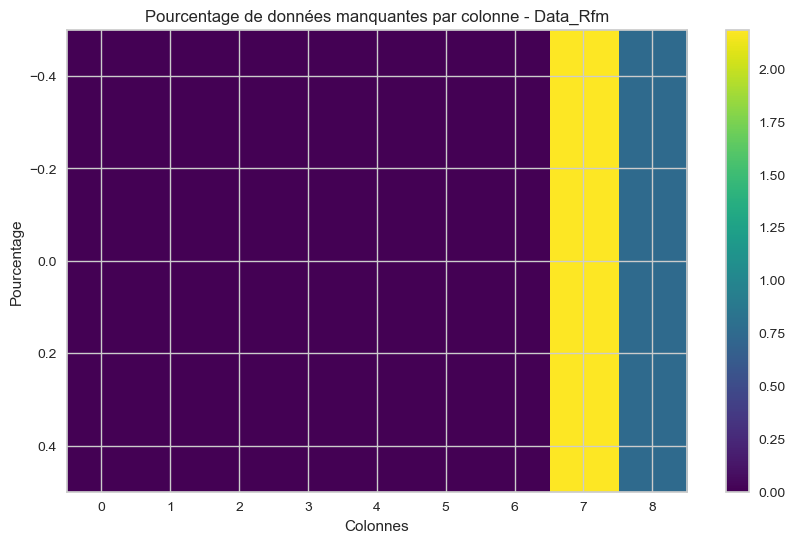

                                date       recency      monetary  \
count                          98351  98351.000000  98351.000000   
mean   2018-01-02 08:36:26.169565952    287.904729    138.297169   
min              2017-01-05 11:56:06     44.000000      0.850000   
25%              2017-09-14 09:43:08    165.000000     45.950000   
50%              2018-01-20 17:20:34    270.000000     87.000000   
75%       2018-05-05 10:22:01.500000    398.000000    149.970000   
max              2018-09-03 09:06:57    650.000000  13440.000000   
std                              NaN    151.507957    211.405054   

          frequency         delay  average_review_score  
count  98351.000000  96203.000000          97607.000000  
mean       1.148295     10.806555              4.106475  
min        1.000000   -189.000000              1.000000  
25%        1.000000      6.000000              4.000000  
50%        1.000000     11.000000              5.000000  
75%        1.000000     16.000000      

In [38]:
rfm_df.name = "Data_Rfm"
data_description(rfm_df)

### suppression des valeurs manquantes

Objectif : Faire une imputation par la moyenne pour les valeurs manquantes dans le but de ne pas perdre  de données sur les clients.

In [39]:
delay_mean = rfm_df["delay"].mean()
average_review_score_mean = rfm_df["average_review_score"].mean()
rfm_df["delay"] = rfm_df["delay"].fillna(delay_mean)
rfm_df["average_review_score"] = rfm_df["average_review_score"].fillna(
    average_review_score_mean
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98351 entries, 0 to 98350
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           98351 non-null  object        
 1   customer_city         98351 non-null  object        
 2   customer_state        98351 non-null  object        
 3   date                  98351 non-null  datetime64[ns]
 4   recency               98351 non-null  int64         
 5   monetary              98351 non-null  float64       
 6   frequency             98351 non-null  int64         
 7   delay                 98351 non-null  float64       
 8   average_review_score  98351 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 6.8+ MB
Nombre de lignes pour Data_Rfm:  98351
Nombre de colonnes pour Data_Rfm:  9
customer_id                     object
customer_city                   object
customer_state     

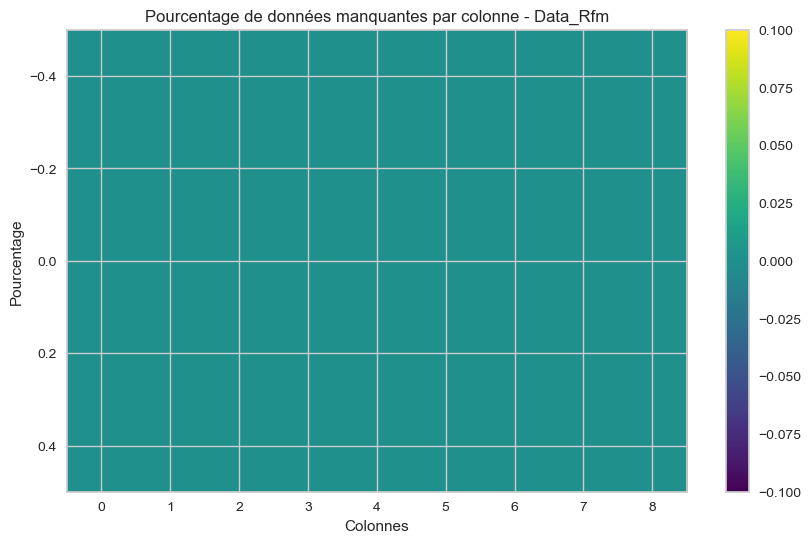

                                date       recency      monetary  \
count                          98351  98351.000000  98351.000000   
mean   2018-01-02 08:36:26.169565952    287.904729    138.297169   
min              2017-01-05 11:56:06     44.000000      0.850000   
25%              2017-09-14 09:43:08    165.000000     45.950000   
50%              2018-01-20 17:20:34    270.000000     87.000000   
75%       2018-05-05 10:22:01.500000    398.000000    149.970000   
max              2018-09-03 09:06:57    650.000000  13440.000000   
std                              NaN    151.507957    211.405054   

          frequency         delay  average_review_score  
count  98351.000000  98351.000000          98351.000000  
mean       1.148295     10.806555              4.106475  
min        1.000000   -189.000000              1.000000  
25%        1.000000      6.000000              4.000000  
50%        1.000000     11.000000              5.000000  
75%        1.000000     16.000000      

In [40]:
rfm_df.name = "Data_Rfm"
data_description(rfm_df)

### Vérification de la distribution

Objectif : vérifier la distribution des valeurs dans les différentes variables.

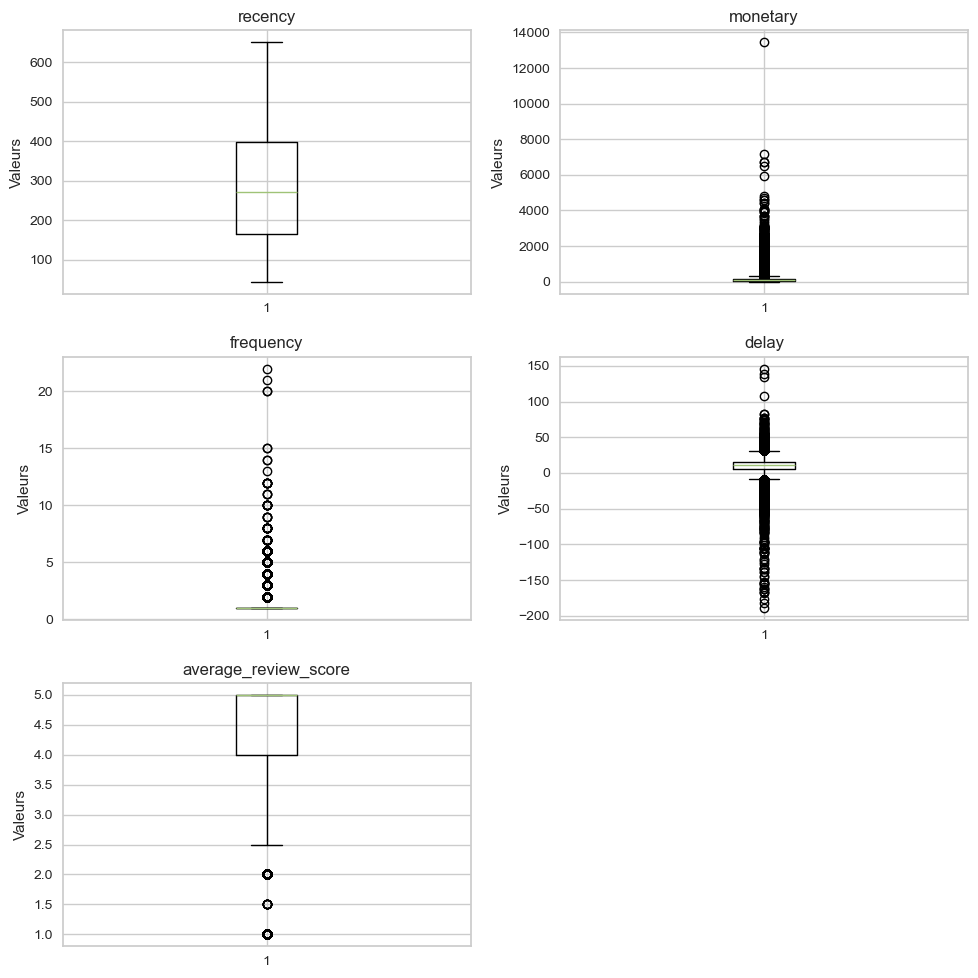

In [41]:
# Vérification du type de colonne
numeric_columns = ["recency", "monetary", "frequency", "delay", "average_review_score"]
rfm_df[numeric_columns] = rfm_df[numeric_columns].apply(pd.to_numeric, errors="coerce")

plt.figure(figsize=(10, 10))
# Boxplot pour chaque variable cible
for i, target in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    plt.boxplot(rfm_df[target].dropna())
    plt.title(target)
    plt.ylabel("Valeurs")

plt.tight_layout()
plt.show()

### Vérification de l'étalement

Objectif : vérifier l'étalement des valeurs et effectuer un passage au log si nécéssaire.

In [42]:
# Sélection des colonnes
columns_to_check = ["recency", "monetary", "frequency", "delay", "average_review_score"]

# Transformation logarithmique si la skewness est supérieure à 1
for target in columns_to_check:
    print(f"{target} skew: {skew(rfm_df[target])}")
    if skew(rfm_df[target].dropna()) > 1:
        rfm_df[target] = np.log1p(rfm_df[target])

recency skew: 0.39515146202168766
monetary skew: 9.678255486488768
frequency skew: 7.770210650822738
delay skew: -2.167471445699847
average_review_score skew: -1.402955586909022


### Vérification de la distribution

Objectif: vérifier l'évolution de la distribution avec le passage au log.

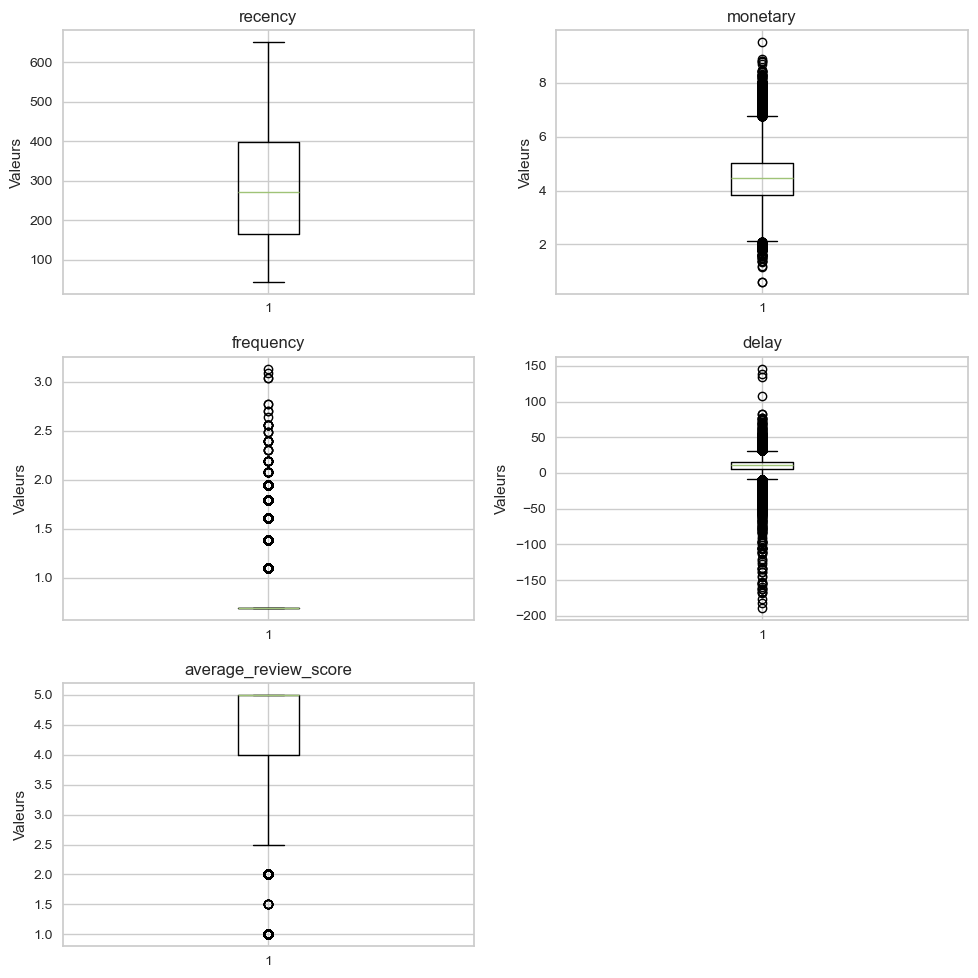

recency skew: 0.39515146202168766
monetary skew: 0.28726279356761225
frequency skew: 3.9021206514699087
delay skew: -2.167471445699847
average_review_score skew: -1.402955586909022


In [43]:
# Vérification du type de colonne
numeric_columns = ["recency", "monetary", "frequency", "delay", "average_review_score"]
rfm_df[numeric_columns] = rfm_df[numeric_columns].apply(pd.to_numeric, errors="coerce")

plt.figure(figsize=(10, 10))
# Boxplot pour chaque variable cible
for i, target in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    plt.boxplot(rfm_df[target].dropna())
    plt.title(target)
    plt.ylabel("Valeurs")

plt.tight_layout()
plt.show()

# Sélection des colonnes
columns_to_check = ["recency", "monetary", "frequency", "delay", "average_review_score"]

# Vérification de la skewness
for target in columns_to_check:
    print(f"{target} skew: {skew(rfm_df[target])}")

## Export du nouveau dataframe

Objectif : exporter le nouveau dataframe RFM dans le but de réaliser les opérations de modélisation et de maintenance.

In [44]:
# export format csv
rfm_df.to_csv("D:\OpenClassroom\Projet_5\RFM_data.csv")